In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

In [10]:
df = pd.read_csv("AIS_100000_data.csv")

In [11]:
len(df)

100000

In [12]:
# Convert datetime
df['BaseDateTime'] = pd.to_datetime(df['BaseDateTime'], errors='coerce')
df['hour'] = df['BaseDateTime'].dt.hour
df['weekday'] = df['BaseDateTime'].dt.dayofweek

# Drop unnecessary columns (if needed)
columns_to_drop = ['MMSI', 'VesselName', 'IMO', 'CallSign']
df.drop(columns=[col for col in columns_to_drop if col in df.columns], axis=1, inplace=True)

# Encode categorical features
le = LabelEncoder()
for col in ['TransceiverClass', 'Status', 'VesselType']:
    if col in df.columns and df[col].dtype == 'object':
      df[col] = le.fit_transform(df[col].astype(str))
    elif col in df.columns and df[col].dtype != 'object':
        # Handle cases where the column exists but is not of object dtype (e.g., already encoded)
        pass

# Fill missing values, handling datetime column separately
for col in df.columns:
    if df[col].dtype == 'datetime64[ns]':
        df[col].fillna(pd.NaT, inplace=True)
    else:
        df[col].fillna(0, inplace=True)

# Normalize features
scaler = MinMaxScaler()
numeric_cols = ['LAT', 'LON', 'SOG', 'COG', 'Heading', 'Length', 'Width', 'Draft', 'Cargo', 'hour']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

/var/folders/mh/0bxs5kls1knd86tyykn_f86c0000gn/T/ipykernel_8677/3630682931.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(pd.NaT, inplace=True)
/var/folders/mh/0bxs5kls1knd86tyykn_f86c0000gn/T/ipykernel_8677/3630682931.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

X = df.drop(['VesselType', 'BaseDateTime'], axis=1)
y = df['VesselType']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred) * 100)
print(classification_report(y_test, y_pred))

Accuracy: 99.33999999999999
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       577
         6.0       1.00      1.00      1.00         1
         8.0       1.00      1.00      1.00         4
        10.0       1.00      1.00      1.00         9
        18.0       1.00      1.00      1.00         3
        20.0       1.00      1.00      1.00         2
        25.0       1.00      1.00      1.00         2
        29.0       1.00      1.00      1.00         3
        30.0       1.00      0.99      0.99      1672
        31.0       1.00      1.00      1.00      6249
        32.0       1.00      1.00      1.00        32
        33.0       1.00      0.94      0.97        88
        34.0       1.00      0.88      0.93         8
        35.0       1.00      0.93      0.96        27
        36.0       0.99      0.96      0.97       934
        37.0       0.98      1.00      0.99      4397
        38.0       1.00      1.00      1.00         4

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


X = df.drop(['SOG','BaseDateTime'], axis=1)
y = df['SOG']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg = RandomForestRegressor()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))

MSE: 0.00013585563467962807


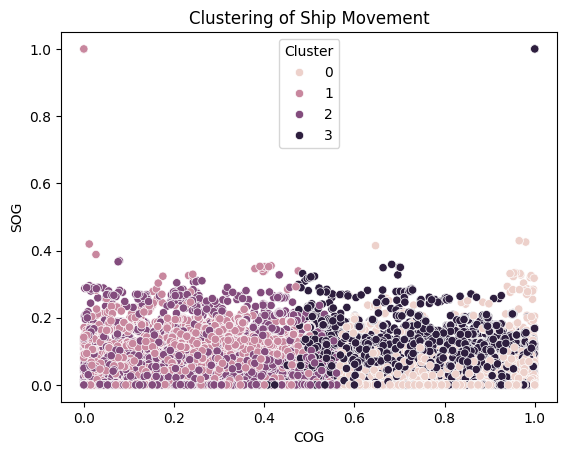

In [15]:
from sklearn.cluster import KMeans

X_cluster = df[['SOG', 'COG', 'Heading', 'Draft']]
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_cluster)

sns.scatterplot(x='COG', y='SOG', hue='Cluster', data=df)
plt.title("Clustering of Ship Movement")
plt.show()

In [16]:
len(df)

100000

In [17]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.01)
df['Anomaly'] = iso.fit_predict(df[['LAT', 'LON', 'SOG', 'COG']])

# -1 = anomaly, 1 = normal
print(df['Anomaly'].value_counts())

Anomaly
 1    99000
-1     1000
Name: count, dtype: int64


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Select MMSI group
df = df.sort_values(by=['BaseDateTime'])

features = ['LAT', 'LON', 'SOG']
seq_data = df[features].values

# Create sequences
def create_sequences(data, step=10):
    X, y = [], []
    for i in range(len(data) - step):
        X.append(data[i:i+step])
        y.append(data[i+step])
    return np.array(X), np.array(y)

X_seq, y_seq = create_sequences(seq_data)

/Users/sagarsharma/miniconda3/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/Users/sagarsharma/miniconda3/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/Users/sagarsharma/miniconda3/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please update th

In [21]:
model = Sequential()
model.add(LSTM(64, input_shape=(X_seq.shape[1], X_seq.shape[2])))
model.add(Dense(3))  # Predict next LAT, LON, SOG
model.compile(optimizer='adam', loss='mse')

model.fit(X_seq, y_seq, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10


/Users/sagarsharma/miniconda3/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2813/2813 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0315 - val_loss: 0.0302
Epoch 2/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0306 - val_loss: 0.0300
Epoch 3/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0305 - val_loss: 0.0306
Epoch 4/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0305 - val_loss: 0.0300
Epoch 5/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0304 - val_loss: 0.0302
Epoch 6/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0304 - val_loss: 0.0302
Epoch 7/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0304 - val_loss: 0.0301
Epoch 8/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0303 - val_loss: 0.0300
Epoch 9/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0303 - val_loss: 0.0301
Epoch 10/10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0303 - val_loss: 0.0301


In [24]:
# Save results
df.to_csv("processed_ais.csv", index=False)

# use Folium for map visualization
import folium
m = folium.Map(location=[48.0, -123.0], zoom_start=5)
for _, row in df.iterrows():
    folium.CircleMarker(location=[row['LAT'], row['LON']],
                        radius=2,
                        color='red' if row['Anomaly'] == -1 else 'blue').add_to(m)
m.save("ais_map.html")

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 709us/step


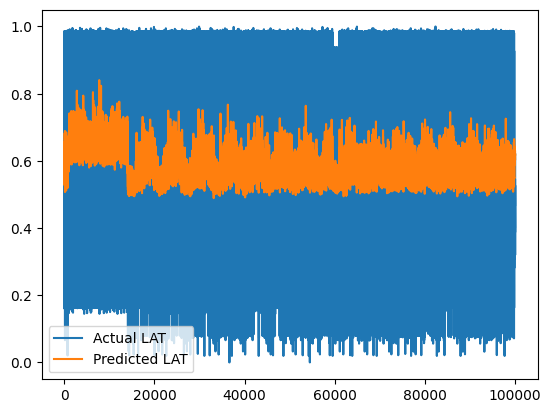

In [25]:
import matplotlib.pyplot as plt

# Compare actual vs predicted LAT/LON
plt.plot(y_seq[:, 0], label='Actual LAT')
plt.plot(model.predict(X_seq)[:, 0], label='Predicted LAT')
plt.legend()
plt.show()

In [26]:
import joblib
joblib.dump(clf, 'vessel_classifier.pkl')
joblib.dump(reg, 'speed_predictor.pkl')


['speed_predictor.pkl']

In [27]:
import joblib
model = joblib.load("speed_predictor.pkl")
joblib.dump(model, "speed_predictor_comp.pkl", compress=3)


['speed_predictor_comp.pkl']

In [28]:
import joblib
model = joblib.load("vessel_classifier.pkl")
joblib.dump(model, "vessel_classifier_comp.pkl", compress=3)

['vessel_classifier_comp.pkl']